# NASA Star Type Classification
dataset: https://www.kaggle.com/datasets/brsdincer/star-type-classification/data

### About Dataset
- Absolute Temperature (in K)
- Relative Luminosity (L/Lo)
- Relative Radius (R/Ro)
- Absolute Magnitude (Mv)
- Star Color
- Spectral Class (O, B, A, F, G, K, M)
- Star Type

Lo = 3.828 x 10^26 Watts (Avg Luminosity of Sun)
Ro = 6.9551 x 10^8 m (Avg Radius of Sun)

Star Type:
- Red Dwarf - 0
- Brown Dwarf - 1
- White Dwarf - 2
- Main Sequence - 3
- Super Giants - 4
- Hyper Giants - 5


In [284]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [285]:
data = pd.read_csv("dataset/Stars.csv")
data

,Temperature,L,R,A_M,Color,Spectral_Class,Type
0,3068,0.002400,0.1700,16.12,Red,M,0
1,3042,0.000500,0.1542,16.60,Red,M,0
2,2600,0.000300,0.1020,18.70,Red,M,0
3,2800,0.000200,0.1600,16.65,Red,M,0
4,1939,0.000138,0.1030,20.06,Red,M,0
...,...,...,...,...,...,...,...
235,38940,374830.000000,1356.0000,-9.93,Blue,O,5
236,30839,834042.000000,1194.0000,-10.63,Blue,O,5
237,8829,537493.000000,1423.0000,-10.73,White,A,5
238,9235,404940.000000,1112.0000,-11.23,White,A,5


## Data Analysis

In [286]:
data.rename(columns={
    "L": "Luminosity",
    "R": "Realative Radius",
    "A_M": "Absolute Magnitude",
    "Spectral_Class": "Spectral Class",
}, inplace=True)
data.columns

Index(['Temperature', 'Luminosity', 'Realative Radius', 'Absolute Magnitude',
       'Color', 'Spectral Class', 'Type'],
      dtype='object')

In [287]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Temperature         240 non-null    int64  
 1   Luminosity          240 non-null    float64
 2   Realative Radius    240 non-null    float64
 3   Absolute Magnitude  240 non-null    float64
 4   Color               240 non-null    object 
 5   Spectral Class      240 non-null    object 
 6   Type                240 non-null    int64  
dtypes: float64(3), int64(2), object(2)
memory usage: 13.3+ KB


In [288]:
#checking fot missing values
data.isnull().sum()

Temperature           0
Luminosity            0
Realative Radius      0
Absolute Magnitude    0
Color                 0
Spectral Class        0
Type                  0
dtype: int64

In [289]:
data.describe()

,Temperature,Luminosity,Realative Radius,Absolute Magnitude,Type
count,240.000000,240.000000,240.000000,240.000000,240.000000
mean,10497.462500,107188.361635,237.157781,4.382396,2.500000
std,9552.425037,179432.244940,517.155763,10.532512,1.711394
min,1939.000000,0.000080,0.008400,-11.920000,0.000000
25%,3344.250000,0.000865,0.102750,-6.232500,1.000000
50%,5776.000000,0.070500,0.762500,8.313000,2.500000
75%,15055.500000,198050.000000,42.750000,13.697500,4.000000
max,40000.000000,849420.000000,1948.500000,20.060000,5.000000


In [290]:
print("Rasporedjenost ciljne promjenjive - tip zvijezde")
print(data["Type"].value_counts())

Rasporedjenost ciljne promjenjive - tip zvijezde
Type
0    40
1    40
2    40
3    40
4    40
5    40
Name: count, dtype: int64


In [291]:
data["Color"] = data["Color"].astype("category")
data["Spectral Class"] = data["Spectral Class"].astype("category")
data["Type Name"] = pd.Categorical.from_codes(data["Type"], 
                                    categories=['Red Dwarf', 'Brown Dwarf', 'White Dwarf', 'Main Sequence' , 'Super Giant', 'Hyper Giant'])

#parametar Spectral Class ima neki poredak: O - najvruće, M - najhladnije zvijezde
data["Spectral Class"] = data["Spectral Class"].cat.reorder_categories(['M','K','G','F','A','B','O'], ordered=True)

In [292]:
data

,Temperature,Luminosity,Realative Radius,Absolute Magnitude,Color,Spectral Class,Type,Type Name
0,3068,0.002400,0.1700,16.12,Red,M,0,Red Dwarf
1,3042,0.000500,0.1542,16.60,Red,M,0,Red Dwarf
2,2600,0.000300,0.1020,18.70,Red,M,0,Red Dwarf
3,2800,0.000200,0.1600,16.65,Red,M,0,Red Dwarf
4,1939,0.000138,0.1030,20.06,Red,M,0,Red Dwarf
...,...,...,...,...,...,...,...,...
235,38940,374830.000000,1356.0000,-9.93,Blue,O,5,Hyper Giant
236,30839,834042.000000,1194.0000,-10.63,Blue,O,5,Hyper Giant
237,8829,537493.000000,1423.0000,-10.73,White,A,5,Hyper Giant
238,9235,404940.000000,1112.0000,-11.23,White,A,5,Hyper Giant


In [293]:
#jedinstvene vrijednosti za atribut Color
print(data["Color"].unique().tolist())

['Red', 'Blue White', 'White', 'Yellowish White', 'Blue white', 'Pale yellow orange', 'Blue', 'Blue-white', 'Whitish', 'yellow-white', 'Orange', 'White-Yellow', 'white', 'yellowish', 'Yellowish', 'Orange-Red', 'Blue-White']


In [294]:
#previše različitih jedinstvenih vrijednosti za boju, mapiramo ih da bi pojednostavili
color_map = {
    r'Blue[\s-]?White|Blue white': 'blue-white',
    r'yellowish|Yellowish|Yellowish White|yellow-white white|white-Yellow': 'yellow-white',
    r'White|Whitish': 'white',
    r'Orange-Red|Pale yellow orange|Orange': 'orange',
    r'Red': 'red',
    r'Blue': 'blue'
}

def map_color(value):
    for pattern, new_value in color_map.items():
        if re.search(pattern, value):
            return new_value
    return value 

data["Color"] = data["Color"].apply(map_color)
print(data["Color"].unique().tolist())

['red', 'blue-white', 'white', 'yellow-white', 'orange', 'blue']


In [295]:
stars_per_class = data.groupby("Type")["Spectral Class"].value_counts()
stars_per_class.unstack()

Spectral Class,M,K,G,F,A,B,O
Type,,,,,,,
0,40,0,0,0,0,0,0
1,40,0,0,0,0,0,0
2,0,0,0,9,7,24,0
3,0,4,0,8,10,13,5
4,9,0,0,0,0,2,29
5,22,2,1,0,2,7,6


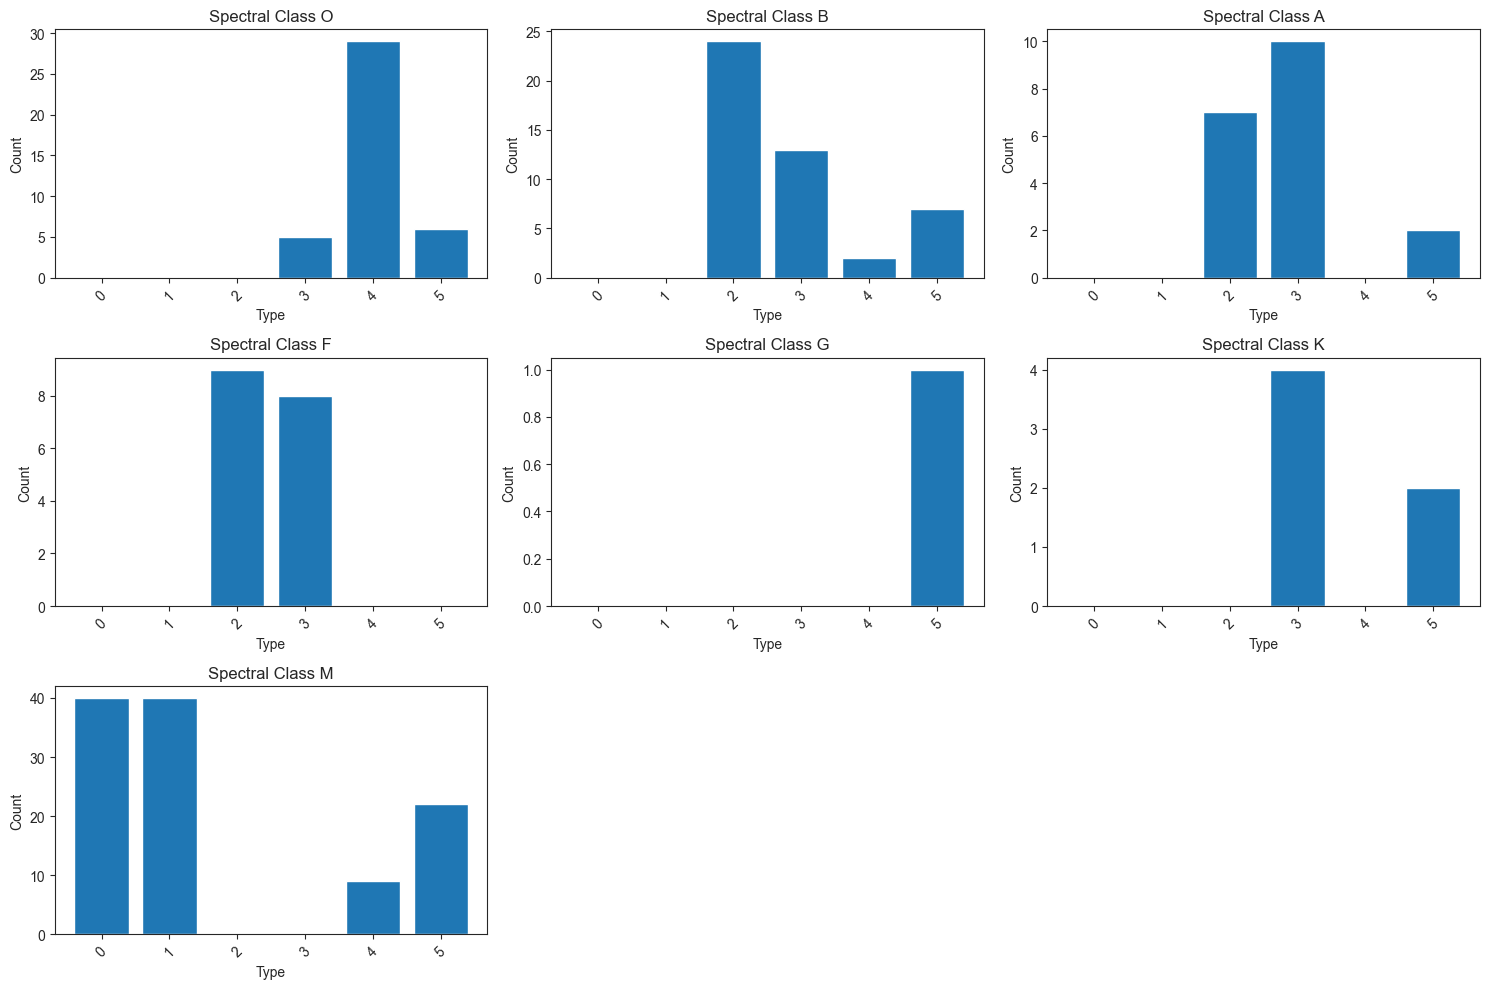

In [296]:
spc_df = stars_per_class.unstack(fill_value=0)
spectral_order = ['O', 'B', 'A', 'F', 'G', 'K', 'M']
spc_df = spc_df.reindex(columns=spectral_order)

fig, axes = plt.subplots(3,3, figsize=(15,10))
axes = axes.flatten()

for i, sc in enumerate(spectral_order):
    counts = spc_df[sc]
    axes[i].bar(counts.index, counts.values)
    axes[i].set_title(f"Spectral Class {sc}")
    axes[i].set_xlabel("Type")
    axes[i].set_ylabel("Count")
    axes[i].set_xticks(counts.index)
    axes[i].set_xticklabels(counts.index, rotation=45)

for j in range(len(spectral_order), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

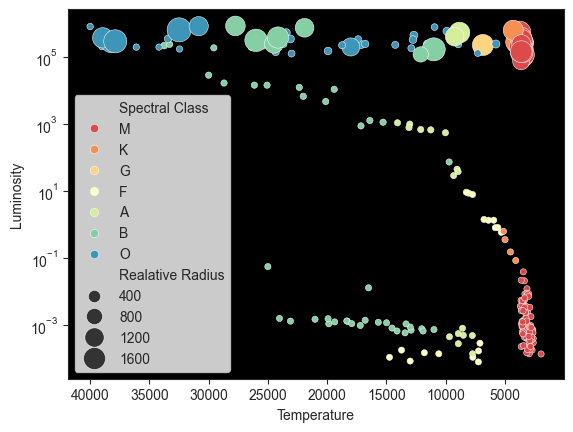

In [297]:
#Hertzprung-Rusell diagram
sns.set_style("ticks")
ax = sns.scatterplot(data, x="Temperature", y="Luminosity", hue="Spectral Class", size="Realative Radius", sizes=(20, 300), palette="Spectral")
ax.invert_xaxis()
ax.set_yscale("log")
ax.set_xlabel("Temperature")
ax.set_ylabel("Luminosity")
ax.set_facecolor('k')

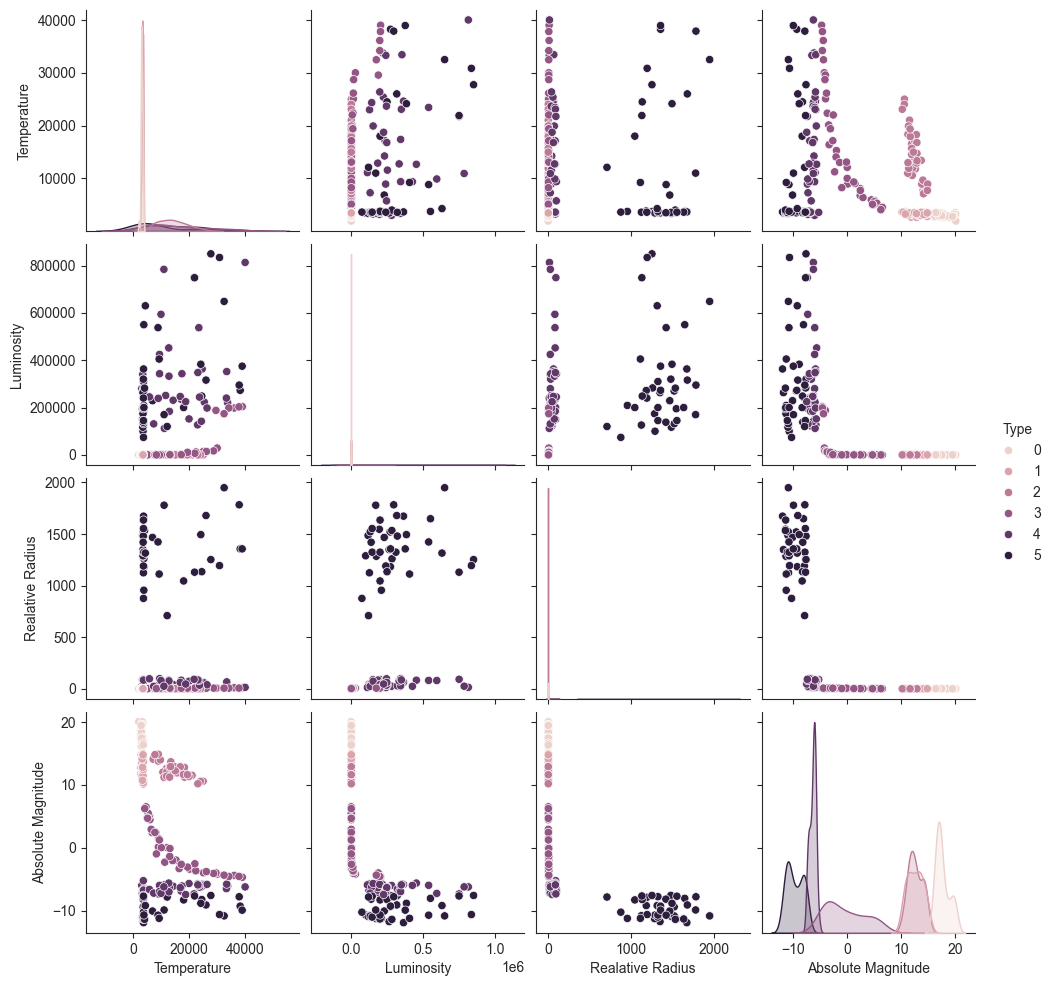

In [298]:
sns.pairplot(data, hue='Type', diag_kind='kde')

<Axes: xlabel='Temperature', ylabel='Absolute Magnitude'>

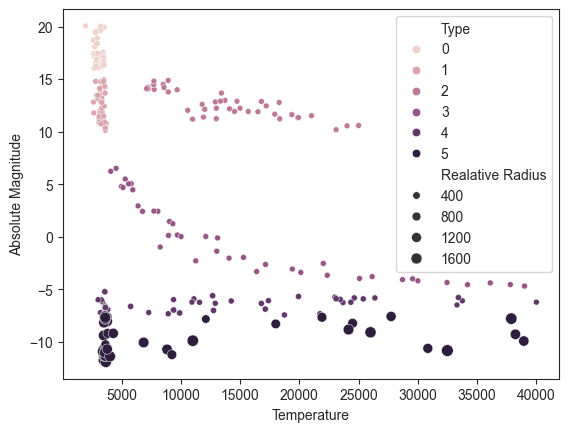

In [299]:
#rasporedjenost klastera u odnosu na Temperature, Absolute Magnitude i Realative Radius
sns.scatterplot(data, x="Temperature", y="Absolute Magnitude", hue='Type', size="Realative Radius")

<Axes: >

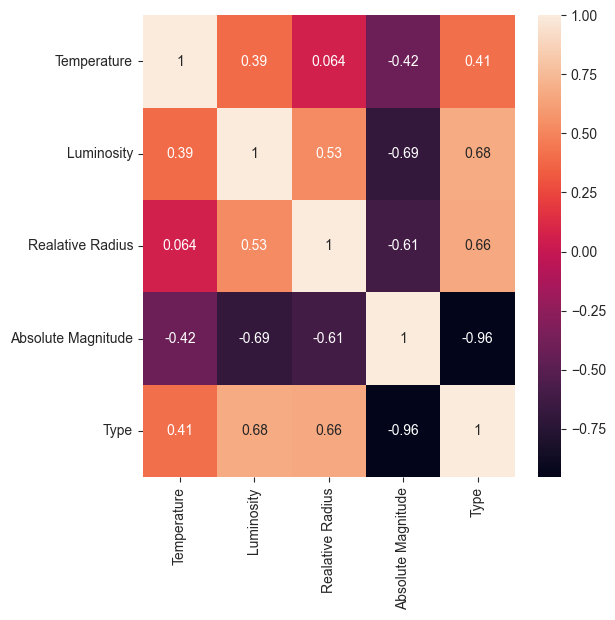

In [300]:
plt.figure(figsize=(6,6))
sns.heatmap(data.corr(numeric_only=True), annot=True)

## Modelling

Classifiers:
- DecisionTreeClassifier
- RandomForestClassifier
- KNeighborsClassifier
- LogisticRegression

In [301]:
spectral_mapping = {'O': 0, 'B': 1, 'A': 2, 'F': 3, 'G': 4, 'K': 5, 'M': 6}
data["Spectral Class Num"] = data["Spectral Class"].map(spectral_mapping)

features = ["Temperature", "Luminosity", "Luminosity", "Absolute Magnitude", "Spectral Class Num"]

X = data[features]
y = data["Type"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [302]:
#DecisionTreeClassifier

clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy: 1.0

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00         6
           3       1.00      1.00      1.00         8
           4       1.00      1.00      1.00         8
           5       1.00      1.00      1.00        11

    accuracy                           1.00        48
   macro avg       1.00      1.00      1.00        48
weighted avg       1.00      1.00      1.00        48


Confusion Matrix:
 [[ 8  0  0  0  0  0]
 [ 0  7  0  0  0  0]
 [ 0  0  6  0  0  0]
 [ 0  0  0  8  0  0]
 [ 0  0  0  0  8  0]
 [ 0  0  0  0  0 11]]


In [303]:
# RandomForestClassifier

rf_clf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
rf_clf.fit(X_train, y_train)

y_pred = rf_clf.predict(X_test)


print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 1.0

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00         6
           3       1.00      1.00      1.00         8
           4       1.00      1.00      1.00         8
           5       1.00      1.00      1.00        11

    accuracy                           1.00        48
   macro avg       1.00      1.00      1.00        48
weighted avg       1.00      1.00      1.00        48

Confusion Matrix:
 [[ 8  0  0  0  0  0]
 [ 0  7  0  0  0  0]
 [ 0  0  6  0  0  0]
 [ 0  0  0  8  0  0]
 [ 0  0  0  0  8  0]
 [ 0  0  0  0  0 11]]


In [304]:
#KNeighborsClassifier

errors = []
for k in range(1, 21):
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(X_train, y_train)
    y_pred_k = model.predict(X_test)
    errors.append(1 - accuracy_score(y_test, y_pred_k)) 

# plt.figure(figsize=(8, 4))
# plt.plot(range(1, 21), errors, marker='o')
# plt.title("Error Rate vs K Value")
# plt.xlabel("K")
# plt.ylabel("Error Rate")
# plt.grid(True)
# plt.show()

optimal_k = range(1, 21)[errors.index(min(errors))]
print(f"Optimal number of neighbor (k): {optimal_k}")

knn = KNeighborsClassifier(n_neighbors=optimal_k)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Optimal number of neighbor (k): 1
Accuracy: 0.8541666666666666

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00         6
           3       1.00      1.00      1.00         8
           4       0.57      0.50      0.53         8
           5       0.67      0.73      0.70        11

    accuracy                           0.85        48
   macro avg       0.87      0.87      0.87        48
weighted avg       0.85      0.85      0.85        48


Confusion Matrix:
 [[8 0 0 0 0 0]
 [0 7 0 0 0 0]
 [0 0 6 0 0 0]
 [0 0 0 8 0 0]
 [0 0 0 0 4 4]
 [0 0 0 0 3 8]]


In [306]:
#Logistic Regression

logreg = LogisticRegression(solver='lbfgs', max_iter=2000)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.875

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       0.78      1.00      0.88         7
           2       1.00      1.00      1.00         6
           3       1.00      0.62      0.77         8
           4       0.70      0.88      0.78         8
           5       0.90      0.82      0.86        11

    accuracy                           0.88        48
   macro avg       0.90      0.89      0.88        48
weighted avg       0.89      0.88      0.87        48


Confusion Matrix:
 [[8 0 0 0 0 0]
 [0 7 0 0 0 0]
 [0 0 6 0 0 0]
 [0 2 0 5 1 0]
 [0 0 0 0 7 1]
 [0 0 0 0 2 9]]
